In [1]:
import sys
sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld

URM_all, _, _, _, _ = ld.getCOOs()
ICM_weighted = ld.getICMselected('7')
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=1234)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13643 ( 0.1%) Users that have less than 1 test interactions


In [4]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {"num_factors": 29, "epochs": 50, "confidence_scaling": "log", "alpha": 0.001, "epsilon": 0.001, "reg": 0.01},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_weighted': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True}
                         }


In [5]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [6]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

In [7]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal

In [ ]:
recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender2 = SLIM_BPR_Cython(URM_train)

model_init(recommender1, 'SLIM_Pure', models_to_combine_best['SLIMER'])
model_init(recommender2, 'SLIM_BPR', models_to_combine_best['SLIMBPR'])

../models_temp/Similarity_Hybrid/SLIM_Pure.zip
Model does not exists, creating...


  1%|█                                                                             | 232/18059 [00:16<07:26, 39.92it/s]

In [9]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [10]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13643 (100.0%) in 16.91 sec. Users per second: 807
RP3betaRecommender 0.22063505734087704
EvaluatorHoldout: Processed 13643 (100.0%) in 25.42 sec. Users per second: 537
P3alphaRecommender 0.20400471373772652


In [11]:
import matplotlib.pyplot as plt

In [15]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(0.95, 0.99, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [16]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 20)

EvaluatorHoldout: Processed 13643 (100.0%) in 26.09 sec. Users per second: 523
0.95 : 0.2206004212870374
EvaluatorHoldout: Processed 13643 (100.0%) in 26.32 sec. Users per second: 518
0.9521052631578947 : 0.22057163159431753
EvaluatorHoldout: Processed 13643 (100.0%) in 28.99 sec. Users per second: 471
0.9542105263157894 : 0.2206085916494185
EvaluatorHoldout: Processed 13643 (100.0%) in 28.40 sec. Users per second: 480
0.9563157894736841 : 0.22067879742969573
EvaluatorHoldout: Processed 13643 (100.0%) in 27.64 sec. Users per second: 494
0.958421052631579 : 0.22065807920568623
EvaluatorHoldout: Processed 13643 (100.0%) in 27.28 sec. Users per second: 500
0.9605263157894737 : 0.22071788660735397
EvaluatorHoldout: Processed 13643 (100.0%) in 27.98 sec. Users per second: 488
0.9626315789473684 : 0.22064266342760833
EvaluatorHoldout: Processed 13643 (100.0%) in 26.37 sec. Users per second: 517
0.9647368421052631 : 0.22072368933891345
EvaluatorHoldout: Processed 13643 (100.0%) in 25.72 sec. 

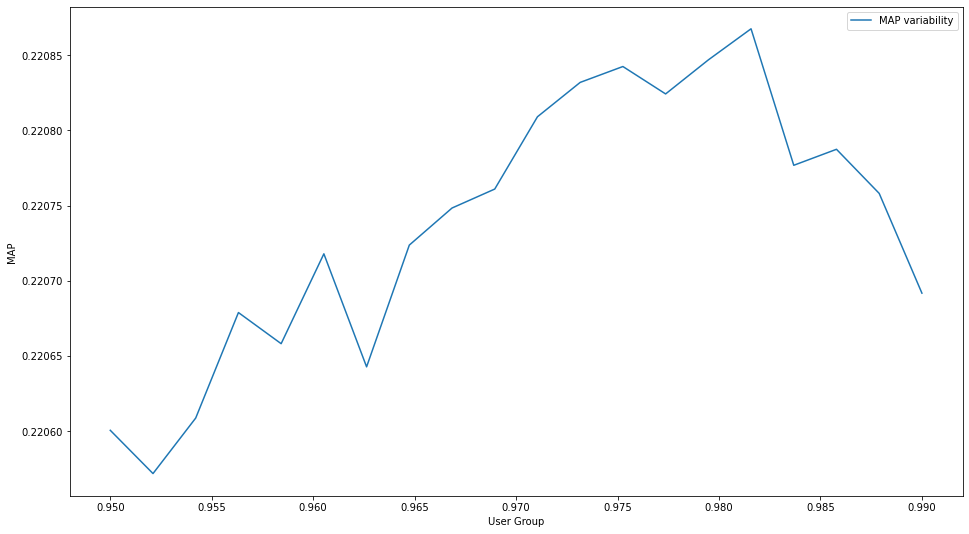

In [19]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [21]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, high, low, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(high, low, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [22]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.9794, 0.9837, 20)

EvaluatorHoldout: Processed 13643 (100.0%) in 26.81 sec. Users per second: 509
0.9794 : 0.22083606454382707
EvaluatorHoldout: Processed 13643 (100.0%) in 25.65 sec. Users per second: 532
0.9796263157894737 : 0.2208632224909807
EvaluatorHoldout: Processed 13643 (100.0%) in 24.78 sec. Users per second: 551
0.9798526315789474 : 0.22085189334841202
EvaluatorHoldout: Processed 13643 (100.0%) in 24.10 sec. Users per second: 566
0.980078947368421 : 0.22086061053461942
EvaluatorHoldout: Processed 13643 (100.0%) in 23.83 sec. Users per second: 573
0.9803052631578948 : 0.22085680603693528
EvaluatorHoldout: Processed 13643 (100.0%) in 24.20 sec. Users per second: 564
0.9805315789473684 : 0.2208540806437165
EvaluatorHoldout: Processed 13643 (100.0%) in 24.46 sec. Users per second: 558
0.9807578947368422 : 0.22085761463812492
EvaluatorHoldout: Processed 13643 (100.0%) in 24.67 sec. Users per second: 553
0.9809842105263158 : 0.2208587606412501
EvaluatorHoldout: Processed 13643 (100.0%) in 26.45 sec.

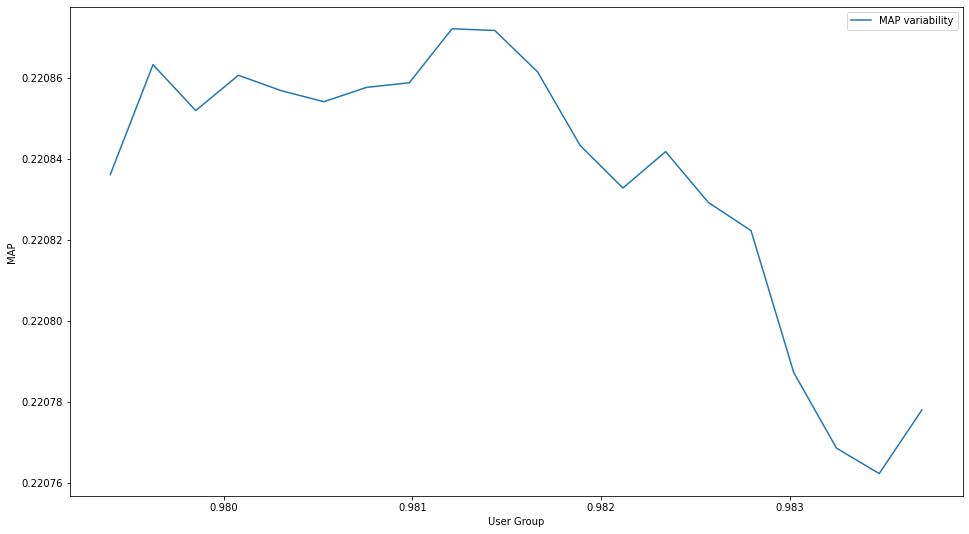

In [23]:
import matplotlib.pyplot as plt

_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability')
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()